# Prostate Cancer
The data for this example, displayed in Figure 1.11, come from a study by Stamey et al. (1989) that examined the correlation between the level of prostate specific antigen (PSA) and a number of clinical measures, in 97 men who were about to receive a radical prostatectomy.

The goal is to predict the log of PSA (lpsa) from a number of measurements including log cancer volume (lcavol), log prostate weight lweight, age, log of benign prostatic hyperplasia amount lbph, seminal vesicle invasion svi, log of capsular penetration lcp, Gleason score gleason, and percent of Gleason scores 4 or 5 pgg45. Figure 1.1 is a scatterplot matrix of the variables. Some correlations with lpsa are evident, but a good predictive model is difficult to construct by eye.

This is a supervised learning problem, known as a regression problem, because the outcome measurement is quantitative. (PAGE 3)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# load training and test data set from file
df = pd.read_csv("../data/Prostate Cancer.txt")
target = ['lpsa']
features = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']

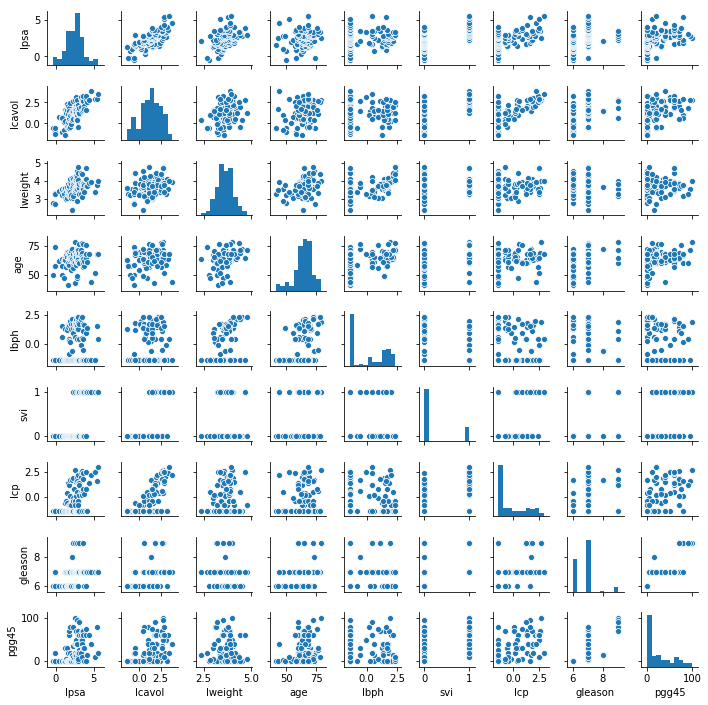

In [3]:
# PAGE 3. FIGURE 1.1. Scatterplot matrix of the prostate cancer data. The first row shows
#         the response against each of the predictors in turn. Two of the predictors, svi and
#         gleason, are categorical.
sns.pairplot(df, vars=target+features, kind="scatter", height=1.1)

In [4]:
# split data to training/test np.arrays
df_train = df[df.train == 'T']
df_test = df[df.train == 'F']
X_train, y_train = df_train[features].values, df_train[target].values
X_test, y_test = df_test[features].values, df_test[target].values
y_test_flat = np.squeeze(y_test)
N_test = y_test_flat.shape[0]

In [5]:
# PAGE 49. The correlation matrix of the predictors given in Table 3.1 shows many
#          strong correlations. Figure 1.1 (page 3) of Chapter 1 is a scatterplot matrix
#          showing every pairwise plot between the variables. We see that svi is a
#          binary variable, and gleason is an ordered categorical variable. We see, for
#          example, that both lcavol and lcp show a strong relationship with the
#          response lpsa, and with each other. We need to fit the effects jointly to
#          untangle the relationships between the predictors and the response.
df[df.train == 'T'][features].corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000


## Base Error Rate

In [6]:
# PAGE 51. prediction using the mean training value of lpsa has
#          a test error of 1.057, which is called the "base error rate".
base_error_rate = mean_squared_error(y_test, np.full(y_test.shape, np.mean(y_train)))
print(f'Baseline Test Error: {base_error_rate:.3f}')

Baseline Test Error: 1.057


## Least Squares

In [7]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

C:\Python64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
# PAGE 50. We fit a linear model to the log of prostate-specific antigen, lpsa, after
#          first standardizing the predictors to have unit variance.
scaler = StandardScaler().fit(np.vstack([X_train, X_test]))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# PAGE 50. We applied least squares estimation to the training set, producing the estimates,
#          standard errors and Z-scores shown in Table 3.2. 
ls = sm.OLS(y_train, sm.add_constant(X_train)).fit()
ls_params = ls.params

# PAGE 50.   TABLE 3.2. Linear model fit to the prostate cancer data. The Z score (t value) is the
#            coefficient divided by its standard error (3.12). Roughly Z score larger than two 
#            in absolute value is significantly nonzero at the p = 0.05 level.
result = zip(['Intercept'] + features, ls_params, ls.bse, ls.tvalues)
print('      Term   Coefficient   Std. Error   Z Score')
print('-----------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>10}   {coefficient:>11.2f}   {std_err:>10.2f}  {z_score:>8.2f}')

      Term   Coefficient   Std. Error   Z Score
-----------------------------------------------
 Intercept          2.46         0.09     27.60
    lcavol          0.68         0.13      5.37
   lweight          0.26         0.10      2.75
       age         -0.14         0.10     -1.40
      lbph          0.21         0.10      2.06
       svi          0.30         0.12      2.47
       lcp         -0.29         0.15     -1.87
   gleason         -0.02         0.14     -0.15
     pgg45          0.27         0.15      1.74


In [10]:
# PAGE 51. The mean prediction error on the test data is 0.521.
y_hat = ls.predict(sm.add_constant(X_test))
ls_error_rate = mean_squared_error(y_test_flat, y_hat)
ls_std_error = np.std((y_test_flat - y_hat)**2, ddof=1)/np.sqrt(N_test)
print(f'Least Squares Test Error: {ls_error_rate:.3f}')
print(f'               Std Error: {ls_std_error:.3f}')

Least Squares Test Error: 0.521
               Std Error: 0.179


## Cross-Validation

In [11]:
from sklearn.model_selection import GridSearchCV, KFold

# PAGE 62. The estimates of prediction error and their standard errors were obtained by
#          tenfold cross-validation; full details are given in Section 7.10.

# with this random state value, our CV results are close to the book's result
rs, K = 69438, 10

# let's write a common function for performing cross-validation
def do_cross_validation(estimator, param_grid):
    # prepare grid search object with 10-fold cross validation
    # it uses neg_mean_squared_error due to the higher is the better approach
    grid_search = GridSearchCV(estimator, param_grid, 
                               cv=KFold(K, True, rs), 
                               scoring='neg_mean_squared_error',
                               return_train_score=True,
                               iid=True)
    grid_search.fit(X_train, y_train)
    
    # convert neg_mean_squared_error to mean squared error and 
    # reshape results to the form where a row correspons to one paramenter's 10
    # cross validation outputs
    cv_erros = -np.vstack([grid_search.cv_results_[f'split{i}_test_score'] 
                           for i in range(K)]).T
    cv_mean_errors = np.mean(cv_erros, axis=1)
    cv_std_errors = np.std(cv_erros, ddof=1, axis=1)/np.sqrt(K)
    
    # PAGE 62. The least complex model within one standard error of the best is chosen
    best_index = np.argmin(cv_mean_errors)
    best_err, best_std_err = cv_mean_errors[best_index], cv_std_errors[best_index]
    selected_model_index = np.argmax(cv_mean_errors < (best_err + best_std_err))
    
    # for each parameter returns: mean error, std error, the best model error, 
    # the best model std error and the selected model index
    return cv_mean_errors, cv_std_errors, best_err, best_std_err, selected_model_index

# calculates error rate and std error for the estimator
def assess_selected_model(estimator):
    # different models return the result in different shapes, so squeeze it
    y_hat = np.squeeze(estimator.predict(X_test))
    error_rate = mean_squared_error(y_test_flat, y_hat)
    std_error = np.std((y_test_flat - y_hat)**2, ddof=1)/np.sqrt(N_test)    
    return error_rate, std_error

In [12]:
# PAGE 62. FIGURE 3.7. Estimated prediction error curves and their standard errors for
#          the various selection and shrinkage methods. Each curve is plotted as a function
#          of the corresponding complexity parameter for that method. The horizontal axis
#          has been chosen so that the model complexity increases as we move from left to
#          right. The estimates of prediction error and their standard errors were obtained by
#          tenfold cross-validation; full details are given in Section 7.10. The least complex
#          model within one standard error of the best is chosen, indicated by the purple
#          vertical broken lines.

# let's write a common plotting function for FIGURE 3.7
ORANGE, BLUE, PURPLE = '#E69F00', '#56B4E9', '#A020F0'
def plot_cv_results(complexity_vals,
                    cv_mean_errors, cv_std_errors,
                    best_err, best_std_err, 
                    selected_model_index):
    plt.plot(complexity_vals, cv_mean_errors, 
             c=ORANGE, linewidth=1)
    plt.errorbar(complexity_vals, cv_mean_errors,
                 color=ORANGE, linestyle='None', marker='o', elinewidth=1,
                 markersize=4, yerr=cv_std_errors, ecolor=BLUE, capsize=4)
    plt.axhline(y=best_err+best_std_err, c=PURPLE, linewidth=1, linestyle='--')
    plt.axvline(x=complexity_vals[selected_model_index], 
                c=PURPLE, linewidth=1, linestyle='--')    

## Ridge Regression

In [13]:
from sklearn.linear_model import Ridge

In [14]:
degress_of_freedom = list(range(9))
parameters = {'alpha': [1e20, 436, 165, 82, 44, 27, 12, 4, 1e-05]}
rd_errs, rd_std_errs, best_err, best_std_err, selected_index = \
    do_cross_validation(Ridge(), parameters)

In [15]:
rd = Ridge(alpha=parameters['alpha'][selected_index]).fit(X_train, y_train)
rd_params = np.hstack(([rd.intercept_], rd.coef_))
rd_error_rate, rd_std_error = assess_selected_model(rd)
print(f'Ridge Test Error: {rd_error_rate:.3f}')
print(f'       Std Error: {rd_std_error:.3f}')

Ridge Test Error: 0.492
       Std Error: 0.164


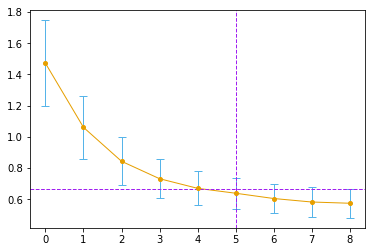

In [16]:
plot_cv_results(degress_of_freedom, rd_errs, rd_std_errs,
                best_err, best_std_err, selected_index)

## Lasso Regression

In [17]:
from sklearn.linear_model import Lasso

In [18]:
shrinkage = [0, 0.102, 0.254, 0.384, 0.504, 0.612, 0.756, 0.883, 1]
parameters = {'alpha': [1, 0.680, 0.380, 0.209, 0.100, 0.044, 0.027, 0.012, 0.001]}
lo_errs, lo_std_errs, best_err, best_std_err, selected_index = \
    do_cross_validation(Lasso(), parameters)

In [19]:
lo = Lasso(alpha=parameters['alpha'][selected_index]).fit(X_train, y_train)
lo_params = np.hstack(([rd.intercept_], rd.coef_))
lo_error_rate, lo_std_error = assess_selected_model(lo)
print(f'Lasso Test Error: {lo_error_rate:.3f}')
print(f'       Std Error: {lo_std_error:.3f}')

Lasso Test Error: 0.479
       Std Error: 0.164


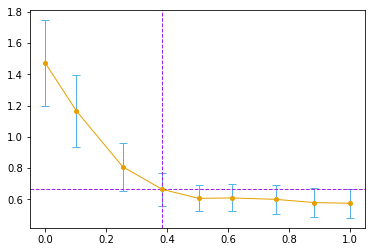

In [20]:
plot_cv_results(shrinkage, lo_errs, lo_std_errs,
                best_err, best_std_err, selected_index)

## Principal Components Regression

In [21]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [22]:
n_directions = list(range(0, 9))
parameters = {'pca__n_components': list(range(1, 9))}
model = Pipeline([('pca', PCA()),
                  ('regression', LinearRegression())])
pc_errs, pc_std_errs, best_err, best_std_err, selected_index = \
    do_cross_validation(model, parameters)

In [23]:
pca = PCA(n_components=parameters['pca__n_components'][selected_index])
lr = LinearRegression()
model = Pipeline([('pca', pca),
                  ('regression', lr)]).fit(X_train, y_train)

# X_train are not centered, so calculation is little bit different
pc_params = np.zeros(8)
intercept = lr.intercept_[0]
for i in range(7):
    pc_params += lr.coef_[0, i]*pca.components_[i, :]
    intercept -= lr.coef_[0, i]*(pca.mean_ @ pca.components_[i, :])

# the parameters are different from the book, but are correct
pc_params = np.hstack(([intercept], pc_params))

pc_error_rate, pc_std_error = assess_selected_model(model)
print(f'Principal Components Regression Error: {pc_error_rate:.3f}')
print(f'                            Std Error: {pc_std_error:.3f}')

Principal Components Regression Error: 0.449
                            Std Error: 0.106


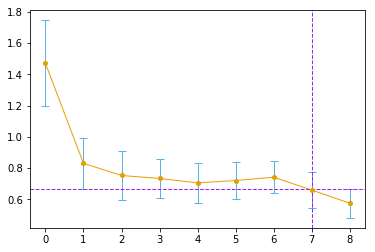

In [24]:
# it is not possible to calculate err & std err for n = 0 directions
# so copy it from lasso results, because it corresponds to baseline
plot_cv_results(n_directions, 
                np.hstack((lo_errs[0], pc_errs)), 
                np.hstack((lo_std_errs[0], pc_std_errs)),
                best_err, best_std_err, selected_index+1)

## Partial Least Squares

In [25]:
from sklearn.cross_decomposition import PLSRegression

In [26]:
parameters = {'n_components': list(range(1, 9))}
ps_errs, ps_std_errs, best_err, best_std_err, selected_index = \
    do_cross_validation(PLSRegression(scale=False), parameters)

In [27]:
# out cross-validation gives 3 components, but let's pretend
# that the result is n = 2 components to be consistent with the book
ps = PLSRegression(n_components=2, scale=False).fit(X_train, y_train)
ps_params = np.hstack((ps.y_mean_, np.squeeze(ps.coef_)))

ps_error_rate, ps_std_error = assess_selected_model(ps)
print(f'Partial Least Squares Test Error: {ps_error_rate:.3f}')
print(f'                       Std Error: {ps_std_error:.3f}')

Partial Least Squares Test Error: 0.527
                       Std Error: 0.150


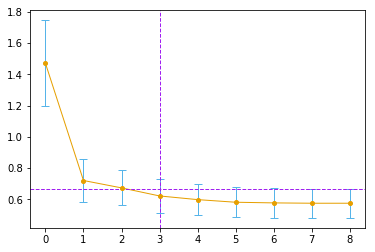

In [28]:
# it is not possible to calculate err & std err for n = 0 directions
# so copy it from lasso results, because it corresponds to baseline
n_directions = list(range(0, 9))
plot_cv_results(n_directions, 
                np.hstack((lo_errs[0], ps_errs)), 
                np.hstack((lo_std_errs[0], ps_std_errs)),
                best_err, best_std_err, selected_index+1)

## Best Subset Regression

In [29]:
from itertools import combinations

In [30]:
class BestSubsetRegression(LinearRegression):
    def __init__(self, subset_size=1):
        LinearRegression.__init__(self)
        self.subset_size = subset_size
    def fit(self, X, y, sample_weight=None):
        best_combination, best_mse = None, None
        best_intercept_, best_coef_ = None, None
        for combination in combinations(range(X.shape[1]), self.subset_size):
            X_tmp = X[:, combination]
            LinearRegression.fit(self, X_tmp, y)
            mse = mean_squared_error(y, self.predict(X_tmp))
            if best_mse is None or best_mse > mse:
                best_combination, best_mse = combination, mse
                best_intercept_, best_coef_ = self.intercept_, self.coef_
        LinearRegression.fit(self, X, y)
        self.intercept_ = best_intercept_
        self.coef_ = np.zeros(shape=self.coef_.shape)
        for i, idx in enumerate(best_combination):
            self.coef_[0, idx] = best_coef_[0, i]

In [31]:
parameters = {'subset_size': list(range(1, 9))}
bs_errs, bs_std_errs, best_err, best_std_err, selected_index = \
    do_cross_validation(BestSubsetRegression(), parameters)

In [32]:
bs = BestSubsetRegression(subset_size=parameters['subset_size'][selected_index])
bs.fit(X_train, y_train)
bs_params = np.hstack((bs.intercept_, np.squeeze(bs.coef_)))

In [33]:
bs_error_rate, bs_std_error = assess_selected_model(bs)
print(f'Best Subset Test Error: {bs_error_rate:.3f}')
print(f'             Std Error: {bs_std_error:.3f}')

Best Subset Test Error: 0.492
             Std Error: 0.143


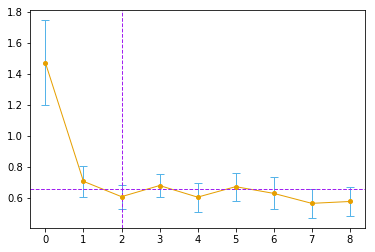

In [34]:
# it is not possible to calculate err & std err for k = 0 subset size
# so copy it from lasso results, because it corresponds to baseline
subset_sizes = list(range(0, 9))
plot_cv_results(subset_sizes, 
                np.hstack((lo_errs[0], bs_errs)), 
                np.hstack((lo_std_errs[0], bs_std_errs)),
                best_err, best_std_err, selected_index+1)